# 2 geopandas 0.9.0重要新特性一览

In [1]:
import geopandas as gpd;gpd.__version__

'0.9.0'

## 2.1 read_file可直接读取到存放单个矢量文件的zip压缩包

In [2]:
gpd.read_file('单geojson压缩包.zip').head(3)

,state,adm1_code,population,geometry
0,Minnesota,USA-3514,5303925,"POLYGON ((-89.59941 48.01027, -89.48888 48.013..."
1,Montana,USA-3515,989415,"POLYGON ((-111.19419 44.56116, -111.29155 44.7..."
2,North Dakota,USA-3516,672591,"POLYGON ((-96.60136 46.35136, -96.53891 46.199..."


In [3]:
gpd.read_file('单shapefile压缩包.zip').head(3)

,state,adm1_code,population,geometry
0,Minnesota,USA-3514,5303925,"POLYGON ((-89.59941 48.01027, -89.48888 48.013..."
1,Montana,USA-3515,989415,"POLYGON ((-111.19419 44.56116, -111.29155 44.7..."
2,North Dakota,USA-3516,672591,"POLYGON ((-96.60136 46.35136, -96.53891 46.199..."


## 2.2 新增对wkt与wkb格式的直接支持

In [4]:
?gpd.GeoSeries.*wkt*

gpd.GeoSeries.from_wkt
gpd.GeoSeries.to_wkt

In [5]:
?gpd.GeoSeries.*wkb*

gpd.GeoSeries.from_wkb
gpd.GeoSeries.to_wkb

In [6]:
g = gpd.GeoSeries.from_wkt(['POINT (30 10)', 'LINESTRING (30 10, 10 30, 40 40)'], crs='EPSG:4326')
g

0                            POINT (30.00000 10.00000)
1    LINESTRING (30.00000 10.00000, 10.00000 30.000...
dtype: geometry

In [7]:
g.to_wkt()

0                       POINT (30 10)
1    LINESTRING (30 10, 10 30, 40 40)
dtype: object

In [8]:
g.to_wkb()

0    b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00...
1    b'\x01\x02\x00\x00\x00\x03\x00\x00\x00\x00\x00...
dtype: object

In [9]:
gpd.GeoSeries.from_wkb(g.to_wkb(), crs='EPSG:4326')

0                            POINT (30.00000 10.00000)
1    LINESTRING (30.00000 10.00000, 10.00000 30.000...
dtype: geometry

## 2.3 新增高度z属性

In [10]:
gpd.GeoSeries.from_wkt(['POINT (0 1 2)']).x

0    0.0
dtype: float64

In [11]:
gpd.GeoSeries.from_wkt(['POINT (0 1 2)']).y

0    1.0
dtype: float64

In [12]:
gpd.GeoSeries.from_wkt(['POINT (0 1 2)']).z

0    2.0
dtype: float64

## 2.4 dissolve()方法新增无字段依赖模式

In [13]:
g = gpd.GeoDataFrame({
    'geometry': gpd.GeoSeries.from_wkt(['POINT (0 0)', 'POINT (1 1)', 'POINT (2 2)'])
})
g['数值'] = range(3)
g

,geometry,数值
0,POINT (0.00000 0.00000),0
1,POINT (1.00000 1.00000),1
2,POINT (2.00000 2.00000),2


In [14]:
# 老方法
g.assign(id_=0).dissolve(by='id_', aggfunc='sum').reset_index(drop=True)

,geometry,数值
0,"MULTIPOINT (0.00000 0.00000, 1.00000 1.00000, ...",3


In [15]:
# 新方法
g.dissolve(by=None, aggfunc='sum')

,geometry,数值
0,"MULTIPOINT (0.00000 0.00000, 1.00000 1.00000, ...",3


## 2.5 新增estimate_utm_crs()方法自动推断投影坐标系

In [16]:
g1 = gpd.GeoDataFrame({
    'geometry': gpd.GeoSeries.from_wkt(['POINT (1 1)'])}, crs='EPSG:4326')
g2 = gpd.GeoDataFrame({
    'geometry': gpd.GeoSeries.from_wkt(['POINT (106 29)'])}, crs='EPSG:4326')
g2.to_crs('EPSG:2381', inplace=True)

In [17]:
g1.estimate_utm_crs() # 基于原始的坐标参考系，给出横轴墨卡托参考系建议

<Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 0°E and 6°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Andorra. Belgium. Benin. Burkina Faso. Denmark - North Sea. France. Germany - North Sea. Ghana. Luxembourg. Mali. Netherlands. Niger. Nigeria. Norway. Spain. Togo. United Kingdom (UK) - North Sea.
- bounds: (0.0, 0.0, 6.0, 84.0)
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
g2.estimate_utm_crs() # 基于原始的坐标参考系，给出横轴墨卡托参考系建议

<Projected CRS: EPSG:32648>
Name: WGS 84 / UTM zone 48N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 102°E and 108°E, northern hemisphere between equator and 84°N, onshore and offshore. Cambodia. China. Indonesia. Laos. Malaysia - West Malaysia. Mongolia. Russian Federation. Singapore. Thailand. Vietnam.
- bounds: (102.0, 0.0, 108.0, 84.0)
Coordinate Operation:
- name: UTM zone 48N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## 2.6 解决了explode()方法与pandas的冲突

In [19]:
from shapely.geometry import MultiPoint, Point

gdf = gpd.GeoDataFrame({
    'V1': [[1, 2, 3], [4, 5], 6],
    'geometry': [Point(0, 0), MultiPoint([(0, 0), (1, 1), (2, 2)]), Point(0, 0)]
})
gdf

,V1,geometry
0,"[1, 2, 3]",POINT (0.00000 0.00000)
1,"[4, 5]","MULTIPOINT (0.00000 0.00000, 1.00000 1.00000, ..."
2,6,POINT (0.00000 0.00000)


In [20]:
gdf.explode() # 默认按矢量列多要素部件展开

V1                 geometry
0 0  [1, 2, 3]  POINT (0.00000 0.00000)
1 0     [4, 5]  POINT (0.00000 0.00000)
  1     [4, 5]  POINT (1.00000 1.00000)
  2     [4, 5]  POINT (2.00000 2.00000)
2 0          6  POINT (0.00000 0.00000)

In [21]:
gdf.explode(column='V1') # 利用column参数兼容pandas中的explode功能

,V1,geometry
0,1,POINT (0.00000 0.00000)
0,2,POINT (0.00000 0.00000)
0,3,POINT (0.00000 0.00000)
1,4,"MULTIPOINT (0.00000 0.00000, 1.00000 1.00000, ..."
1,5,"MULTIPOINT (0.00000 0.00000, 1.00000 1.00000, ..."
2,6,POINT (0.00000 0.00000)


## 2.7 绘图方面的新特性

In [22]:
!pip show descartes

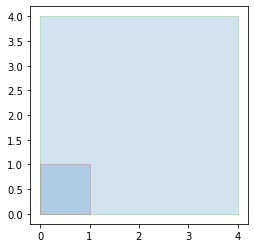

In [23]:
from shapely.geometry import Polygon

g1 = gpd.GeoDataFrame({'geometry': [Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])]})
g2 = gpd.GeoDataFrame({'geometry': [Polygon([(0, 0), (4, 0), (4, 4), (0, 4)])]})

ax = g1.plot(alpha=0.2, edgecolor='red')
g2.plot(alpha=0.2, edgecolor='green', ax=ax);